#**Deep Learning Homework 4: *Recurrent Neural Networks & Transformer***
### MSc Computer Science, Data Science, Cybersecurity @UNIPD
### 2nd semester - 6 ECTS
### Prof. Alessandro Sperduti, Prof. Nicolò Navarin and Dr. Luca Pasa
---
In this homework, we will explore how to develop a simple Recurrent Neural Network (RNN) for sentiment analysis. We will use the IMDB dataset---it contains the text of some reviews and the sentiment given by their authors (either positive or negative). The input to the RNN is the sequence of words that compose a review, so the learning task consists in predicting the overall sentiment of the review.
In the first part, we will learn how to develop a simple RNN, then we will explore the differences in terms of computational load, number of parameters, and performances with respect to more advanced recurrent models, like LSTM and GRU. Subsequently, we experiment with the bi-directional model to unveil the strengths and the weaknesses of this technique. Finally, we will solve the same classification problem with a Transformer, in order to have a closer look at its internal functioning.

---
##**Important Instructions for Submissions:**

Generally, in the homeworks, you will be either required to complete a part of Python code or to answer questions in text cells. Code and text cells where you are expected to write your answers have been marked by `%STARTCODE` and `%ENDCODE` or `%STARTEXT` and `%ENDTEXT` tags, respectively. Note that you should never change, move or remove these two tags, otherwise your answers will be __not__ valid. As you will see in this notebook, each cell that includes a `[TO COMPLETE]` part has been put between these placeholders.

#Requirements

In [ ]:
!pip3 install datasets skorch pandas~=1.5 torch~=1.13 torchinfo torchdata~=0.5 torchtext~=0.14 torchvision~=0.14 torchaudio~=0.13

#Imports

In [ ]:
import torch
from torch import nn
from torch.nn import Embedding, RNN, LSTM, GRU, Linear, Transformer
import torch.nn.functional as F
from torchinfo import summary
from torchtext.datasets import IMDB
from torch.utils.data import DataLoader, Dataset, random_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchvision.transforms import Lambda
from timeit import default_timer as timer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(42)
rng = np.random.default_rng(seed=4242)

#Data Loading and Preprocessing

###Load dataset:
In this HW, we use the same datset used in the HW2, the IMDB dataset. The dataset contains 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative). As usual, for speed and efficiency, we will use only a subset of the dataset. Reviews have been preprocessed, and each review is encoded as a sequence of word indexes. We load the data from the PyTorch database and then split the data into train, validation and test set.

In [ ]:
train, test = IMDB(root="dataset", split=('train', 'test'))
Tr, Ts = list(train), list(test)
rng.shuffle(Tr)
rng.shuffle(Ts)
len_train, len_val, len_test = 25000, 12500, 12500 # Whole data
train_data, val_data, test_data = Tr[:len_train], Ts[:len_val], Ts[len_val:len_val+len_test]

In [ ]:
len(train_data), len(val_data), len(test_data)

(25000, 12500, 12500)

In [ ]:
idx = 10
label_samp, text_samp = train_data[idx]
print(f"text: {text_samp}")
print(f"label: {label_samp}")

text: Assuming this won't end up a straight-to-video release, I would have to say void this title at all costs. Unless you're bored of good, well-executed movies, that is. I saw this last night at AFI Dallas, and I left with 20 minutes remaining, simply because I didn't care anymore (about the plot, not about insulting the director...that is awkward). When you can spot a goof only 5 minutes into the movie (a shot out, shattered window before any shots are fired...and then the window breaks with the first shot), things are going to bad. Let's just say this is only an indicator of things to come...unfortunately.<br /><br />I'll spare you all the details, but this is sub-par in every manner, even the half-assed acting by Michael Madsen is disappointing when you're expecting half-assed acting from him. And the rape scene...Christ! "Shut up and take it" should never be used in a rape scene. EVER.<br /><br />3/10
label: 1


Let's check the dataset statistics.

In [ ]:
datasets = {'train':train_data, 'val':val_data, 'test':test_data}
for key in datasets:
  label_dist = {}
  dataset = datasets[key]
  for lb, txt in dataset:
    if lb not in label_dist:
      label_dist.setdefault(lb, 1)
    else:
      label_dist[lb] += 1
  print(f"{key}:")
  print(label_dist)


train:
{1: 12500, 2: 12500}
val:
{2: 6245, 1: 6255}
test:
{2: 6255, 1: 6245}


In [ ]:
tokenizer = get_tokenizer('basic_english')

def create_tokens(dataset):
  for sample in dataset:
    yield tokenizer(sample[1])

vocab = build_vocab_from_iterator(create_tokens(train_data), specials=["<oov>", "<sos>"], max_tokens=10000)
vocab.set_default_index(vocab["<oov>"])
print(f"Our vocabulary is made of {len(vocab)} tokens-index pairs.")

Our vocabulary is made of 10000 tokens-index pairs.


In [ ]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [ ]:
print(vocab.get_itos())  # top 10000 freq words (including special chars)

['<oov>', '<sos>', 'the', '.', ',', 'and', 'a', 'of', 'to', "'", 'is', 'it', 'in', 'i', 'this', 'that', 's', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', ')', '(', 'you', 't', 'on', 'not', 'he', 'are', 'his', 'have', 'be', 'one', '!', 'all', 'at', 'they', 'by', 'an', 'who', 'from', 'so', 'like', 'there', 'her', 'or', 'just', 'about', 'if', 'has', 'out', 'what', '?', 'some', 'good', 'can', 'more', 'when', 'she', 'very', 'even', 'my', 'no', 'up', 'would', 'time', 'which', 'only', 'story', 'really', 'their', 'see', 'had', 'we', 'were', 'me', 'than', 'well', 'much', '-', 'get', 'been', 'people', 'will', 'also', 'other', 'bad', 'into', 'do', 'because', 'great', 'first', 'how', 'him', 'don', 'most', 'its', 'made', 'then', 'them', 'way', 'could', 'make', 'too', 'any', 'after', 'movies', 'think', 'characters', 'character', 'watch', 'films', 'two', 'many', 'seen', 'being', 'never', 'little', 'plot', 'acting', 'where', 'best', 'love', 'did', 'life', 'show', 'know', 'does', 'ever', 'here',

In [ ]:
word_index = {k:v for (k, v) in enumerate(vocab.get_itos())}

In [ ]:
def decode_review(word_ids):
    return " ".join([word_index.get(word_id, "<err>") for word_id in word_ids])

print(text_samp)
print("\n")
print(decode_review(text_pipeline(text_samp)))

Assuming this won't end up a straight-to-video release, I would have to say void this title at all costs. Unless you're bored of good, well-executed movies, that is. I saw this last night at AFI Dallas, and I left with 20 minutes remaining, simply because I didn't care anymore (about the plot, not about insulting the director...that is awkward). When you can spot a goof only 5 minutes into the movie (a shot out, shattered window before any shots are fired...and then the window breaks with the first shot), things are going to bad. Let's just say this is only an indicator of things to come...unfortunately.<br /><br />I'll spare you all the details, but this is sub-par in every manner, even the half-assed acting by Michael Madsen is disappointing when you're expecting half-assed acting from him. And the rape scene...Christ! "Shut up and take it" should never be used in a rape scene. EVER.<br /><br />3/10


assuming this won ' t end up a straight-to-video release , i would have to say void

To keep the length of the all the input sequences same, we define the padding function. All the sentence less than the lenght of 500 will be padded with zeros and greater than 500 will be truncated. Notice that we will pad and truncate sequences right-wise, so that processing the sequences, the final hidden states of the recurrent networks will correspond to the final words of each sequence in the batch.



In [ ]:
def sent_padding(sent_vec, maxlen):
  sent_vec = torch.tensor(sent_vec)
  maxlen -= len(sent_vec)
  return F.pad(sent_vec, (maxlen, 0))


print(sent_padding([1,2,3], maxlen=6))
print(sent_padding([1,2,3,4,5,6,7,8,9], maxlen=6))

tensor([0, 0, 0, 1, 2, 3])
tensor([4, 5, 6, 7, 8, 9])


In [ ]:
seq_len = 500
sent_padding(text_pipeline(text_samp), maxlen=seq_len)

tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class CustomDataset(Dataset):

  def __init__(self, dataset, seq_len=seq_len):
    super().__init__()
    self.dataset = dataset
    self.seq_len = seq_len

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    label, text = self.dataset[idx]
    label = label_pipeline(label)
    txt_rep = sent_padding(text_pipeline(text), maxlen=self.seq_len)
    label, txt_rep = torch.tensor(label, dtype=torch.float32), torch.tensor(txt_rep, dtype=torch.long)
    return label.to(device), txt_rep.to(device)

In [ ]:
train_dataset = CustomDataset(train_data)
val_dataset = CustomDataset(val_data)
test_dataset = CustomDataset(test_data)

In [ ]:
batch_size=256
dataloader_training = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_validation = DataLoader(val_dataset, batch_size=batch_size)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size)

#Model Definition

Let's define the model:
- The first layer is an Embedding layer, with input_dim=vocab_dim and output_dim=10. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batches of shape (batch size, 500, 10)
- The second layer is the recurrent one. In particular, in this case, we use a [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)
- The output layer

### Model Comparison

In order to perform a fair comparison of the models RNN, LSTM and GRU make sure they use more or less the same number of parameters.

In the next cell, we define our simple RNN used for binary classification. The class has two main methods, the constructor (`init()`) and the `forward()` method.

In the constructor, the input parameters are used to define the layers and hyperparameters of the RNN. The layers that are defined include an embedding layer (`self.embedding`), a recurrent layer (`self.rnn`), and a linear layer (`self.linear`). The constructor also sets up various parameters such as the embedding input size, the embedding output size, the hidden size, the number of layers, the batch size, the RNN type, and whether or not the RNN is bidirectional.

The `forward()` method takes a batch of input data (`x`) and applies the layers defined in the constructor in a specific sequence. First, the input is passed through the embedding layer to create embeddings of the input tokens. These embeddings are then permuted to be of the correct shape for the RNN layer, which expects inputs of the form (`seq_len, batch_size, H_in`). The RNN layer is then applied to these embeddings, producing both the RNN output (`rnn_out`) and the last hidden state (`self.last_hidden`). Finally, the output of the RNN is passed through a linear layer and flattened to produce the final output of the network, which is a sigmoid activation function applied to a tensor of shape (`batch_size`). This output is then returned.

In [ ]:
class My_RNN(nn.Module):
  def __init__(self, vocab_length, emb_dim, hidden_size, num_layers,
               batch_size, RNN_type, bidirectional, device=device):
    super().__init__()
    self.emb_in_dim = vocab_length  # 10000
    self.emb_out_dim = emb_dim  # 10
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.bidirectional = bidirectional
    self.batch_size = batch_size
    self.RNN_type = RNN_type
    self.target_size = 1  # binary classification
    self.device = device
    self.D = 2 if self.bidirectional else 1  # enable/disable bidirectional

    valid_types = {'Simple RNN':RNN, 'LSTM':LSTM, 'GRU':GRU}
    assert self.RNN_type in valid_types.keys(), f'You must choose one of {valid_types.keys()} types'

    self.embedding = Embedding(self.emb_in_dim, self.emb_out_dim)

    chosen_rnn = valid_types[self.RNN_type]
    self.rnn = chosen_rnn(input_size=self.emb_out_dim, hidden_size=self.hidden_size,
                          num_layers=self.num_layers, bidirectional = self.bidirectional)

    self.linear = Linear(self.D*self.hidden_size, self.target_size)

  def forward(self, x):
    #x: (batch_size, 500)
    self.embeds = self.embedding(x)
    #embeds: (batch_size, 500, 10)
    #But rnn receives inputs of: (500, batch_size, 10) (seq_len, batch_size, H_in)
    self.embeds = self.embeds.permute(1, 0, 2)
    #embeds: (500, batch_size, 10) -> Now the shape is correct
    rnn_out, self.last_hidden = self.rnn(self.embeds)
    #rnn_out: (500, 256, 2*5:10) -> (seq_len, batch_size, D*hidden_size)
    #h_n: (1, 256, hidden_size) -> (D*num_layers, batch_size, hidden_size)
    output = self.linear(rnn_out[-1, :, :])
    #output: (256, 1) -> (batch_size, target_size)
    output = output.flatten()
    #output: (256) -> (batch_size)
    return F.sigmoid(output)

### [TO COMPLETE] Simple RNN

We define a RNN model and evaluate its performance. Your task is to choose the right loss function and motivate your choice.



`%STARTEXT`

ANSWER: Since it is a binary classification problem , we use the binary cross entropy loss BCELoss. Using the principal of maximum likelihood,the cost function can be written as the cross-entropy between training labels and the probability predictions from the sigmoid function in the output of the model

`%ENDTEXT`

`%STARTCODE`

In [ ]:
vocab_length = len(vocab)
emb_dim = 10
hidden_size = 32
num_layers = 1
RNN_type = 'Simple RNN' #possible choices -> ['Simple RNN', 'LSTM', 'GRU']
bidirectional = False

EPOCHS = 20
lr = 1e-3

torch.cuda.set_per_process_memory_fraction(0.8)

model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)

criterion = nn.BCELoss()#[TO COMPLETE]
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
summary(model)

Layer (type:depth-idx)                   Param #
My_RNN                                   --
├─Embedding: 1-1                         100,000
├─RNN: 1-2                               1,408
├─Linear: 1-3                            33
Total params: 101,441
Trainable params: 101,441
Non-trainable params: 0

`%ENDCODE`

Now we can train our model. Try to grasp how a training loop is defined in PyTorch and what each line does!

In [ ]:
def train(model, optimizer, dataloader_train, dataloader_val, epochs=EPOCHS):
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  for epoch in range(epochs):
    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (label, text) in enumerate(dataloader_train):
      optimizer.zero_grad()
      logits = model(text)
      loss = criterion(logits, label)
      total_loss_train += loss
      loss.backward()
      optimizer.step()

      labels_form_logits = lambda x: 0. if x < 0.5 else 1.
      logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
      total_acc_train += (logits == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)

    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (label, text) in enumerate(dataloader_val):
            logits = model(text)
            loss = criterion(logits, label)
            total_loss_val += loss
            logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
            total_acc_val += (logits == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val)
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
  return loss_train, acc_train, loss_val, acc_val

In [ ]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 53.28%, Loss: 0.68867671 ---------------- Val_Acc: 57.06%, Val_Loss: 0.68052477
epoch: 2 -> Accuracy: 58.14%, Loss: 0.67421991 ---------------- Val_Acc: 51.43%, Val_Loss: 0.69730628
epoch: 3 -> Accuracy: 55.99%, Loss: 0.67906445 ---------------- Val_Acc: 58.85%, Val_Loss: 0.66737580
epoch: 4 -> Accuracy: 62.34%, Loss: 0.64852446 ---------------- Val_Acc: 62.29%, Val_Loss: 0.64806885
epoch: 5 -> Accuracy: 65.25%, Loss: 0.62633902 ---------------- Val_Acc: 64.53%, Val_Loss: 0.63279164
epoch: 6 -> Accuracy: 67.53%, Loss: 0.60811943 ---------------- Val_Acc: 67.39%, Val_Loss: 0.60957789
epoch: 7 -> Accuracy: 68.03%, Loss: 0.59942877 ---------------- Val_Acc: 66.86%, Val_Loss: 0.61088264
epoch: 8 -> Accuracy: 71.10%, Loss: 0.56947464 ---------------- Val_Acc: 68.70%, Val_Loss: 0.59368593
epoch: 9 -> Accuracy: 73.42%, Loss: 0.54261833 ---------------- Val_Acc: 71.33%, Val_Loss: 0.56714094
epoch: 10 -> Accuracy: 74.91%, Loss: 0.52372140 ---------------- Val_Acc: 71.66%, 

It's time to plot the results...

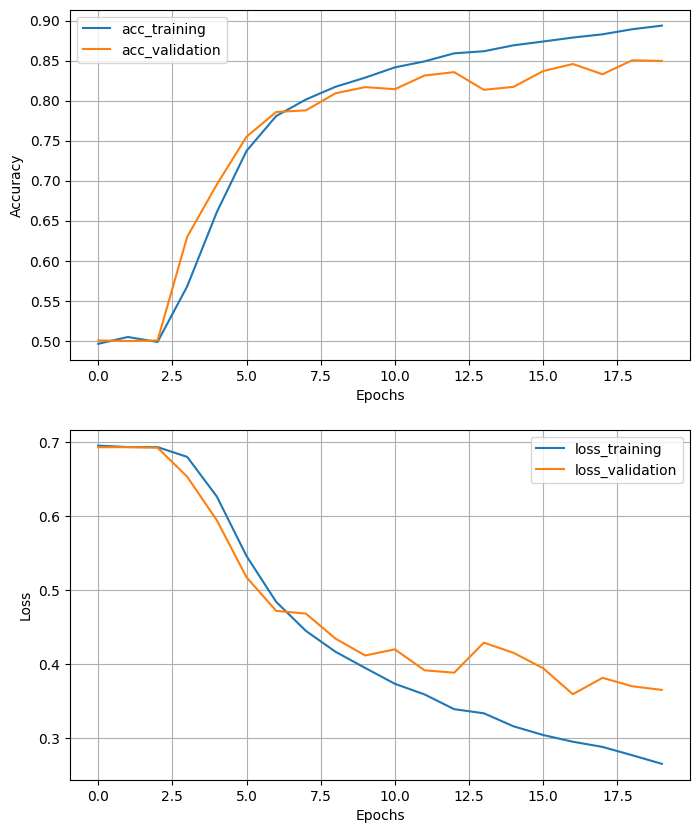

In [ ]:
def plot_learning_acc_and_loss(loss_tr, acc_tr, loss_val, acc_val):

    plt.figure(figsize=(8, 10))

    plt.subplot(2, 1, 1)
    plt.grid()
    plt.plot(range(EPOCHS), acc_tr, label='acc_training')
    plt.plot(range(EPOCHS), acc_val, label='acc_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.grid()
    plt.plot(range(EPOCHS), loss_tr, label='loss_training')
    plt.plot(range(EPOCHS), loss_val, label='loss_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.show()

plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

...and see the performances on the test set:

In [ ]:
def test(model, dataloader_test=dataloader_test):
  model.eval()
  total_acc_test, total_count_test, n_batches_test, loss = 0, 0, 0, 0
  for idx, (label, text) in enumerate(dataloader_test):
      pre_label = model(text)
      loss += criterion(pre_label, label)
      labels_form_pre_label = lambda x: 0. if x < 0.5 else 1.
      pre_label = torch.tensor(list(map(labels_form_pre_label, pre_label))).to(model.device)
      total_acc_test += (pre_label == label).sum().item()
      total_count_test += label.size(0)
      n_batches_test += 1
  accuracy_test = total_acc_test/total_count_test
  loss_test = loss/n_batches_test
  print(f"Test Loss: {loss_test:.8f}", end=' ---------- ')
  print(f"Test Accuracy: {100*accuracy_test:.4f}%")


In [ ]:
test(model)

Test Loss: 0.46417469 ---------- Test Accuracy: 79.9440%


We should achieve ~60% accuracy on test set. Lets see if we can improve further!

### [TO COMPLETE] LSTM

In this Exercise, you have to implement [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) model, similar to the previous one that, instead of exploiting the RNN layer, use an LSTM layer. Print the model summary. Then, train it and plot the values of accuracy and loss. Finally, discuss the differences in terms of performance, the number of parameters, and training time. Note that you can use a different number of units than the one used in the RNN example.

`%STARTCODE`

In [ ]:
vocab_length = len(vocab)
emb_dim = 10
hidden_size = 20
num_layers = 1
RNN_type = 'LSTM'
bidirectional = False

EPOCHS = 20
lr = 1e-3

model_LSTM = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_LSTM.parameters(), lr=lr)# [TO COMPLETE]
summary(model_LSTM)

Layer (type:depth-idx)                   Param #
My_RNN                                   --
├─Embedding: 1-1                         100,000
├─LSTM: 1-2                              2,560
├─Linear: 1-3                            21
Total params: 102,581
Trainable params: 102,581
Non-trainable params: 0

In [ ]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model_LSTM, optimizer, dataloader_training, dataloader_validation, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 53.15%, Loss: 0.68964851 ---------------- Val_Acc: 55.46%, Val_Loss: 0.68494707
epoch: 2 -> Accuracy: 59.10%, Loss: 0.66782618 ---------------- Val_Acc: 61.48%, Val_Loss: 0.65146941
epoch: 3 -> Accuracy: 65.30%, Loss: 0.62306881 ---------------- Val_Acc: 66.98%, Val_Loss: 0.60983527
epoch: 4 -> Accuracy: 70.25%, Loss: 0.57644433 ---------------- Val_Acc: 71.30%, Val_Loss: 0.56327581
epoch: 5 -> Accuracy: 74.86%, Loss: 0.51911801 ---------------- Val_Acc: 74.22%, Val_Loss: 0.52170318
epoch: 6 -> Accuracy: 77.55%, Loss: 0.47890395 ---------------- Val_Acc: 77.03%, Val_Loss: 0.48160744
epoch: 7 -> Accuracy: 80.74%, Loss: 0.42861822 ---------------- Val_Acc: 78.41%, Val_Loss: 0.45604399
epoch: 8 -> Accuracy: 81.87%, Loss: 0.40823036 ---------------- Val_Acc: 80.22%, Val_Loss: 0.43616167
epoch: 9 -> Accuracy: 83.98%, Loss: 0.37380961 ---------------- Val_Acc: 79.15%, Val_Loss: 0.44734871
epoch: 10 -> Accuracy: 84.96%, Loss: 0.35584596 ---------------- Val_Acc: 80.66%, 

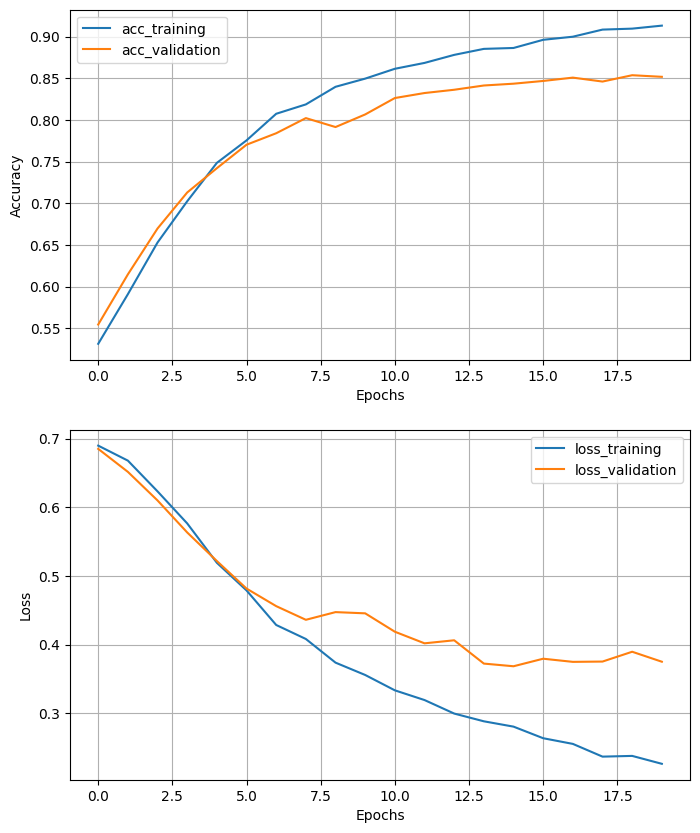

In [ ]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [ ]:
test(model_LSTM)

Test Loss: 0.36847791 ---------- Test Accuracy: 85.6480%


`%ENDCODE`

`%STARTEXT`

ANSWER: With the LSTM model, the training time was 306 seconds, 10 seconds more than the RNN model trained on the same dataset.Since i could use a different number of units than the RNN, to not increase the complexity too much compared to the previous case ,taking in consideration the possible additional parameters in the LSTM unit structure, i reduced the number of hidden layers from 32 to 20 but the overall number of parameters remains slightly higher 102,581 compared to the 101,441 in the RNN model . I increased the number of epochs to 20 to get a good stationary value of the loss instead of the last value in a significantly decreasing plot not yet completely fit. Consequntly the training time is much longer but the accuracy also increases. To be fair i will use the same number of epochs to compare the different fitted models.The overall accuracy of the LSTM model on the test set is around 86% ,it increased by around 6% compared to the 80% of the RNN model.

`%ENDTEXT`

### [TO COMPLETE] GRU

In this Exercise, you have to implement [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html) model, similar to the previous one that, instead of exploiting the RNN layer, use an GRU layer. Print the model summary. Then, train it and plot the values of accuracy and loss. Finally, discuss the differences in terms of performance, the number of parameters, and training time. Note that you can use a different number of units than the one used in the RNN example.

`%STARTCODE`

In [ ]:
vocab_length = len(vocab)
emb_dim = 10
hidden_size = 32
num_layers = 1

RNN_type = 'GRU'
bidirectional = False

EPOCHS = 20
lr = 1e-3
model_GRU = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)# [TO COMPLETE]
optimizer = torch.optim.Adam(model_GRU.parameters(), lr=lr)
summary(model_GRU)

Layer (type:depth-idx)                   Param #
My_RNN                                   --
├─Embedding: 1-1                         100,000
├─GRU: 1-2                               4,224
├─Linear: 1-3                            33
Total params: 104,257
Trainable params: 104,257
Non-trainable params: 0

In [ ]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model_GRU, optimizer, dataloader_training, dataloader_validation, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 53.64%, Loss: 0.68863487 ---------------- Val_Acc: 54.58%, Val_Loss: 0.68567467
epoch: 2 -> Accuracy: 58.63%, Loss: 0.66620189 ---------------- Val_Acc: 63.56%, Val_Loss: 0.63745373
epoch: 3 -> Accuracy: 67.50%, Loss: 0.60265148 ---------------- Val_Acc: 69.42%, Val_Loss: 0.58305931
epoch: 4 -> Accuracy: 73.17%, Loss: 0.53819716 ---------------- Val_Acc: 74.98%, Val_Loss: 0.51387978
epoch: 5 -> Accuracy: 77.69%, Loss: 0.47489059 ---------------- Val_Acc: 77.97%, Val_Loss: 0.46597403
epoch: 6 -> Accuracy: 81.20%, Loss: 0.42240185 ---------------- Val_Acc: 80.48%, Val_Loss: 0.42898509
epoch: 7 -> Accuracy: 83.39%, Loss: 0.38130653 ---------------- Val_Acc: 81.71%, Val_Loss: 0.40322277
epoch: 8 -> Accuracy: 84.58%, Loss: 0.35741705 ---------------- Val_Acc: 82.46%, Val_Loss: 0.39034823
epoch: 9 -> Accuracy: 86.30%, Loss: 0.32814795 ---------------- Val_Acc: 83.63%, Val_Loss: 0.36963066
epoch: 10 -> Accuracy: 87.59%, Loss: 0.30202788 ---------------- Val_Acc: 84.73%, 

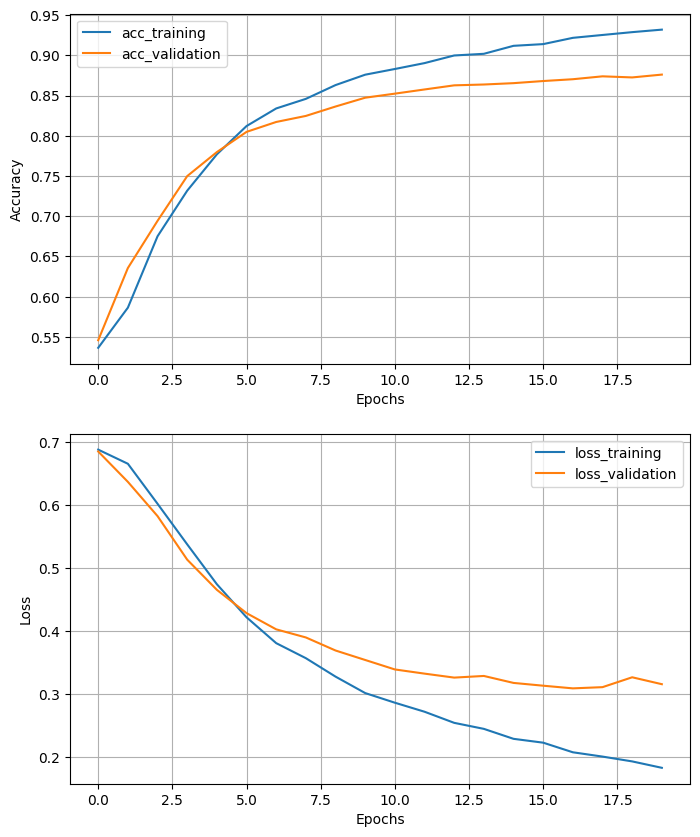

In [ ]:
plot_learning_acc_and_loss(loss_train,accuracy_train,loss_val,accuracy_val)

In [ ]:
test(model_GRU)

Test Loss: 0.32368806 ---------- Test Accuracy: 87.5760%


`%ENDCODE`

`%STARTEXT`

ANSWER:With the GRU model, the training time was 302 seconds, 6 seconds more than the RNN model trained on the same dataset and 4 seconds less than the LSTM.For the GRU model i kept the number of hidden layers as 32, since its unit structure is less complex than the LSTM, so the overall number of parameters 104,257 is slightly higher than LSTM 102,581 and RNN 101,441. The overall accuracy of the LSTM model on the test set is around 87% ,it increased by around 7% compared to the 80% of the RNN model.

`%ENDTEXT`

#BiDirectional

Let's also have a look at the performances of a bidirectional LSTM instead of a simple LSTM. Try to understand what is the difference with respect to the previous model and use again the same loss you used before. This is just an extra model, so it will not be graded.


In [ ]:
vocab_length = len(vocab)
emb_dim = 10
hidden_size = 32
num_layers = 1
RNN_type = 'LSTM' #possible choices -> ['Simple RNN', 'LSTM', 'GRU']
bidirectional = True

EPOCHS = 20
lr = 3e-4

model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)

criterion = nn.BCELoss()# COMPLETE
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
summary(model)

Layer (type:depth-idx)                   Param #
My_RNN                                   --
├─Embedding: 1-1                         100,000
├─LSTM: 1-2                              11,264
├─Linear: 1-3                            65
Total params: 111,329
Trainable params: 111,329
Non-trainable params: 0

In [ ]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 51.79%, Loss: 0.69242960 ---------------- Val_Acc: 52.65%, Val_Loss: 0.69162023
epoch: 2 -> Accuracy: 53.28%, Loss: 0.69096941 ---------------- Val_Acc: 54.03%, Val_Loss: 0.69011420
epoch: 3 -> Accuracy: 54.36%, Loss: 0.68865484 ---------------- Val_Acc: 55.08%, Val_Loss: 0.68633527
epoch: 4 -> Accuracy: 57.25%, Loss: 0.67819083 ---------------- Val_Acc: 51.60%, Val_Loss: 0.73566699
epoch: 5 -> Accuracy: 52.99%, Loss: 0.69508421 ---------------- Val_Acc: 56.34%, Val_Loss: 0.68395257
epoch: 6 -> Accuracy: 57.50%, Loss: 0.67833328 ---------------- Val_Acc: 60.45%, Val_Loss: 0.66307306
epoch: 7 -> Accuracy: 61.56%, Loss: 0.65696090 ---------------- Val_Acc: 62.40%, Val_Loss: 0.65188777
epoch: 8 -> Accuracy: 63.15%, Loss: 0.64651453 ---------------- Val_Acc: 64.02%, Val_Loss: 0.63796318
epoch: 9 -> Accuracy: 63.97%, Loss: 0.63911641 ---------------- Val_Acc: 65.50%, Val_Loss: 0.63025099
epoch: 10 -> Accuracy: 65.30%, Loss: 0.62820935 ---------------- Val_Acc: 66.33%, 

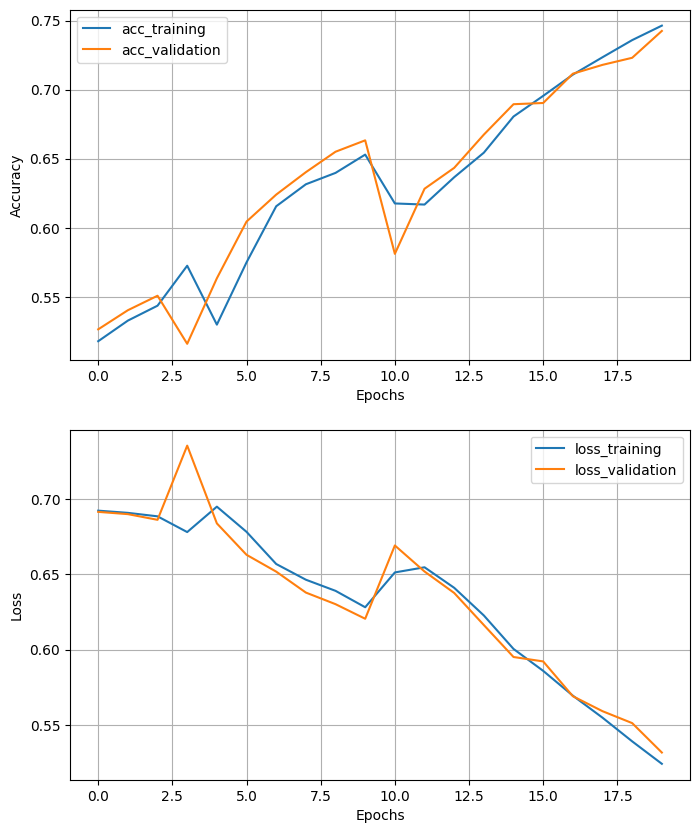

In [ ]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [ ]:
test(model)

Test Loss: 0.53566486 ---------- Test Accuracy: 73.7280%


# Explore relations between words

We will now quickly explore the properties of the embeddings learned by the model. Each embedding encodes the meaning of a word inferring it from the way it is used in the dataset. One possible way to explore the meaning encoded in the embeddings is check whether analogies that we make between concepts are reflected also in the embeddings as geometric properties. In particular, we will compute the difference between the embeddings of two related words, thus encoding their relation in a vector. Then, we will compute the same measure between a few couples of vectors and check if the couple which has the most similar measure corresponds to words that have the same kind of relation as the first ones. You can try different couples of words, and you may find out that sometimes the encoding of words meanings is the one we might expect - that's why carefully choosing the training data is very important!

In [ ]:
def word_embedder(word):
  word_high_dim = sent_padding(text_pipeline(word), maxlen=seq_len).to(device)
  word_low_dim_embedded = model.embedding(word_high_dim)[-1]
  return word_low_dim_embedded

EMB_VOCAB = {}
for word in vocab.get_itos():
  EMB_VOCAB[word] =  word_embedder(word)

In [ ]:
def cosine_similarity(u, v):
    return torch.dot(u,v) / (torch.sqrt(torch.sum(u * u)) * torch.sqrt(torch.sum(v * v)))

def word_matcher(ref1, ref2, tgt3, candidates, EMB_VOCAB):
  max_thr = -np.inf
  e_ref1, e_ref2, e_tgt3 = EMB_VOCAB[ref1], EMB_VOCAB[ref2], EMB_VOCAB[tgt3]
  for w in candidates:
    e_w = EMB_VOCAB[w]
    sim = cosine_similarity(e_ref2 - e_ref1, e_w - e_tgt3)
    if sim > max_thr:
      result = w
      max_thr = sim
  return result

w1, w2, w3 = 'man', 'woman', 'king'
w4_cand = ['soldier', 'queen', 'prophet']
w4 = word_matcher(w1, w2, w3, w4_cand, EMB_VOCAB)
print(f'The relation between {w1} -> {w2} is like the realtion between {w3} -> {w4}')

w1, w2, w3 = 'germany', 'berlin', 'italy'
w4_cand = ['spain', 'rome', 'germany', 'france']
w4 = word_matcher(w1, w2, w3, w4_cand, EMB_VOCAB)
print(f'The relation between {w1} -> {w2} is like the realtion between {w3} -> {w4}')

The relation between man -> woman is like the realtion between king -> queen
The relation between germany -> berlin is like the realtion between italy -> spain


### [TO COMPLETE] Transformer

Let's now use a [Transformer](https://arxiv.org/abs/1706.03762) to perform the same task considered in the previous exercise.

The structure of the transformer is defined as follows:
*   A multi-head attention layer
*   Dropout operation (`dropout_att`)
*   Layer Normalization (`layernorm_att`)
*   A feedforward Neural Network, Sequential, and Dense layer
*   Dropout operation (`dropout_fnn`)
*   Layer Normalization (`layernorm_fnn`) that has in input the summation of the attention layer output and the feedforward NN output

Your task is to experiment with different hyperparameters values and try to find a configuration of the Transformer that can beat the RNNs. In the cell below, write a short comment on the impact of each hyperparameter on model performance according to your observations.

`%STARTEXT`

ANSWER:I tried a value n_head of the attention to 5 , while fixing d_model=5 and num_encoder_layers and num_decoder_layers to 5 . I got an accuracy of around 81% on the validation set. I kept d_model =5 as it seems to be a suggested value when looking at the previous cells. So i tried setting n_head =1 , the only other divisor to a prime number and it had a slightly lower accuracy of around 79%.


With d_model=5, n_head=1,num_encoder_layers=3,num_decoder_layers=3,dropout=0.1, dim_feedforward 128 ,i get 85% accuracy on the test set.
Increasing d_model to 10 the accuracy is 85.7% , no notable difference but it is around the same value as the previously trained GRU and LSTM models.
Increasing dropout to 0.3 there is a slight decrease by around 1% in accuracy.
I keep getting an OutOfMemory error when i try running the last cell in the notebook with various other parameter values. This is the best model i found with the available memory , with around the same accuracy as the LSTM and GRU models while 5% increase over the simple RNN model.

`%ENDTEXT`

In [ ]:
new_seq_len = 200
train_dataset_trns = CustomDataset(train_data, seq_len=new_seq_len)
val_dataset_trns = CustomDataset(val_data, seq_len=new_seq_len)
test_dataset_trns = CustomDataset(test_data, seq_len=new_seq_len)

batch_size=256
dataloader_training_trns = DataLoader(train_dataset_trns, batch_size=batch_size, shuffle=True)
dataloader_validation_trns = DataLoader(val_dataset_trns, batch_size=batch_size)
dataloader_test_trns = DataLoader(test_dataset_trns, batch_size=batch_size)

In [ ]:
class My_Transform(nn.Module):
  def __init__(self, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout, layer_norm_eps, device=device):
    super().__init__()
    self.device = device

    self.emb_en = Embedding(num_embeddings=len(vocab), embedding_dim=d_model)
    self.emb_de = Embedding(num_embeddings=2, embedding_dim=d_model)
    #2: because of binary classification

    self.transformer = Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers,
                                   num_decoder_layers=num_decoder_layers, dim_feedforward=dim_feedforward,
                                   dropout=dropout, layer_norm_eps=layer_norm_eps)

    self.linear = Linear(d_model, 1)#1: because of binary classification

  def forward(self, x, y):

    #x: (batch_size, seq_len) -> (256, 200)
    #y: (batch_size) -> (256)

    y = torch.roll(y, shifts=1, dims=0) #right shifted

    self.embedded_src = self.emb_en(x)
    #self.embedded_src: (batch_size, seq_len, d_model) -> (256, 200, 5)

    '''
    Transformer requires src_dim and trg_dim of (S, N, E)
    (S, N, E) -> (Seq_len, Batch_size, Embed_dim) -> (seq_len, batch_size, d_model)
        - self.embedded_src must be permuted
        - self.embedded_trg must be reshaped accordingly
    Transformer will produce an output of dim (T, N, E)
    (T, N, E) -> (Target_len, Batch_size, Embed_dim) -> (1, batch_size, d_model)
    '''

    self.embedded_src = self.embedded_src.permute(1, 0, 2)
    #self.embedded_src: (seq_len, batch_size, d_model) -> (200, 256, 5)
    self.embedded_trg = self.emb_de(y.unsqueeze(0).long())
    #self.embedded_trg: (seq_len:target_len, batch_size, d_model) -> (1, 256, 5)

    trns_out = self.transformer(self.embedded_src, self.embedded_trg)
    #trns_out: (target_len, batch_size, d_model) -> (1, 256, 5)

    out = self.linear(trns_out)
    #out: (1, 256, 1)

    return F.sigmoid(out.squeeze()) #(batch_size) -> (256) : Like y

`%STARTCODE`

In [ ]:
d_model=5 #[TO COMPLETE]
nhead= 1#[TO COMPLETE]
num_encoder_layers= 3#[TO COMPLETE]
num_decoder_layers=3#[TO COMPLETE]
dim_feedforward=128
dropout=0.1
layer_norm_eps=1e-5

EPOCHS = 20
lr = 1e-3

transformer = My_Transform(d_model, nhead, num_encoder_layers, num_decoder_layers,
                           dim_feedforward, dropout, layer_norm_eps).to(device)

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=lr)

summary(transformer)

Layer (type:depth-idx)                                                 Param #
My_Transform                                                           --
├─Embedding: 1-1                                                       50,000
├─Embedding: 1-2                                                       10
├─Transformer: 1-3                                                     --
│    └─TransformerEncoder: 2-1                                         --
│    │    └─ModuleList: 3-1                                            4,659
│    │    └─LayerNorm: 3-2                                             10
│    └─TransformerDecoder: 2-2                                         --
│    │    └─ModuleList: 3-3                                            5,049
│    │    └─LayerNorm: 3-4                                             10
├─Linear: 1-4                                                          6
Total params: 59,744
Trainable params: 59,744
Non-trainable params: 0

`%ENDCODE`

In [ ]:
def train_trns(model, optimizer, dataloader_train, dataloader_val, epochs=EPOCHS):
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  for epoch in range(epochs):
    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (label, text) in enumerate(dataloader_train):

      optimizer.zero_grad()
      logits = model(text, label)
      loss = criterion(logits, label)
      total_loss_train += loss
      loss.backward()
      optimizer.step()

      labels_form_logits = lambda x: 0. if x < 0.5 else 1.
      logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
      total_acc_train += (logits == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)

    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (label, text) in enumerate(dataloader_val):

            logits = model(text, label)
            loss = criterion(logits, label)
            total_loss_val += loss
            logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
            total_acc_val += (logits == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val)
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
  return loss_train, acc_train, loss_val, acc_val

In [ ]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train_trns(transformer, optimizer, dataloader_training_trns, dataloader_validation_trns, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 49.88%, Loss: 0.69833809 ---------------- Val_Acc: 50.06%, Val_Loss: 0.69301295
epoch: 2 -> Accuracy: 51.40%, Loss: 0.69222349 ---------------- Val_Acc: 57.10%, Val_Loss: 0.68913627
epoch: 3 -> Accuracy: 61.58%, Loss: 0.65311104 ---------------- Val_Acc: 68.64%, Val_Loss: 0.60049427
epoch: 4 -> Accuracy: 71.10%, Loss: 0.57522291 ---------------- Val_Acc: 73.66%, Val_Loss: 0.53695500
epoch: 5 -> Accuracy: 75.88%, Loss: 0.51223338 ---------------- Val_Acc: 76.98%, Val_Loss: 0.49039954
epoch: 6 -> Accuracy: 79.28%, Loss: 0.46189702 ---------------- Val_Acc: 77.13%, Val_Loss: 0.48611680
epoch: 7 -> Accuracy: 81.47%, Loss: 0.42147943 ---------------- Val_Acc: 80.28%, Val_Loss: 0.43583134
epoch: 8 -> Accuracy: 82.67%, Loss: 0.40138710 ---------------- Val_Acc: 79.26%, Val_Loss: 0.46110374
epoch: 9 -> Accuracy: 83.73%, Loss: 0.38083437 ---------------- Val_Acc: 81.18%, Val_Loss: 0.41287109
epoch: 10 -> Accuracy: 84.71%, Loss: 0.36159331 ---------------- Val_Acc: 81.74%, 

`%STARTCODE`

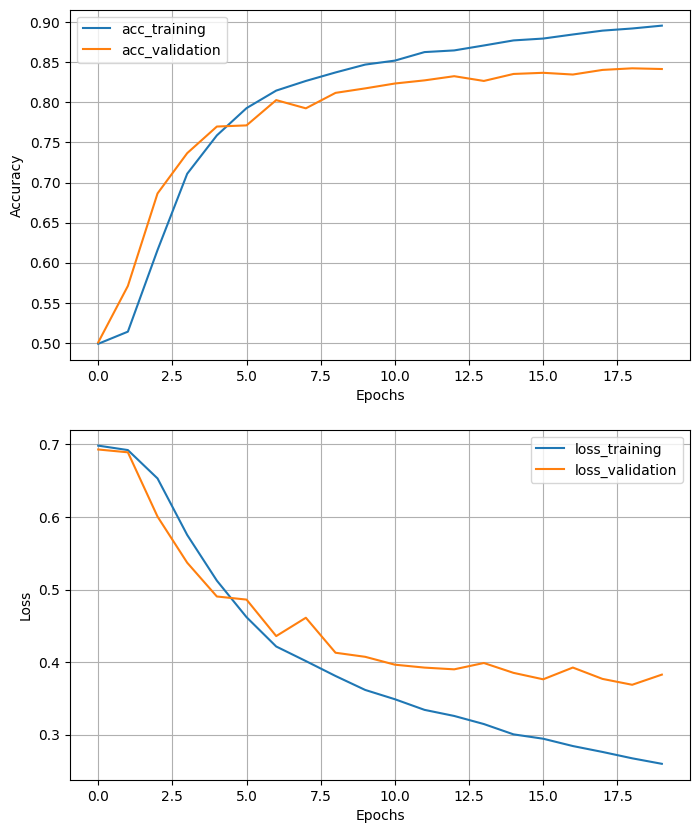

In [ ]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

`%ENDCODE`

In [ ]:
def test_trns(model, dataloader_test):
  model.eval()
  total_acc_test, total_count_test, n_batches_test, loss = 0, 0, 0, 0
  for idx, (label, text) in enumerate(dataloader_test):
      pre_label = model(text, label)
      loss += criterion(pre_label, label)
      labels_form_pre_label = lambda x: 0. if x < 0.5 else 1.
      pre_label = torch.tensor(list(map(labels_form_pre_label, pre_label))).to(model.device)
      total_acc_test += (pre_label == label).sum().item()
      total_count_test += label.size(0)
      n_batches_test += 1
  accuracy_test = total_acc_test/total_count_test
  loss_test = loss/n_batches_test
  print(f"Test Loss: {loss_test:.8f}", end=' ---------- ')
  print(f"Test Accuracy: {100*accuracy_test:.4f}%")

`%STARTCODE`

In [ ]:

gc.collect()
torch.cuda.empty_cache()
#torch.cuda.set_per_process_memory_fraction(1.)

test_trns(transformer, dataloader_test_trns)

Test Loss: 0.37023586 ---------- Test Accuracy: 84.5600%


`%ENDCODE`